# Exercise 2.1

In [1]:
%matplotlib inline
import random
import numpy
import matplotlib.pyplot as plt
import tqdm

In [2]:
print('Pr = Pr(greedy|e>0.5) + Pr(greedy|e<0.5) =', 0.5 + 0.5*0.5)

# Check it through experimentation
import random
eps = 0.5
a1 = 0
a2 = 0
N = 100000
for i in range(N):
    if random.random() > 0.5: #select the greedy option
        a1 += 1
    else: # Select equally amongst all actions
        if random.random() > 0.5:
            a1 += 1
        else:
            a2 += 1

print('Pr(a1) = ', a1/N)
print('Pr(a2) = ', a2/N)

Pr = Pr(greedy|e>0.5) + Pr(greedy|e<0.5) = 0.75
Pr(a1) =  0.75165
Pr(a2) =  0.24835


# Exercise 2.2
Estimate of the true value (eqn 2.1):

$Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i = a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i = a}}$

Gready action selection:

$A_t = \text{argmax}_{a} Q_t(a)$

Epsilon gready selection:

$    A_t= 
\begin{cases}
    \textrm{argmax}_{a} Q_t(a),& \text{if } X \geq \epsilon\\
    \text{sample uniformly},              & \text{otherwise}
\end{cases}$

Given Q1(a)=0: A1=1 could have been $\epsilon$, was likely a greedy action. R1=-1

Given Q2(1)=-1: A2=2 likely a greed action, could have been $\epsilon$. R2=1

Given Q3(1)=-1, Q3(2)=1: A3=2 likley a greedy action, could have been $\epsilon$. R3=-2

Given Q4(1)=-1, Q4(2)=-1/2: A4=2 is definitely an $\epsilon$ action as A(3,4) is argmax Q. R4=2

Given Q5(1)=-1, Q5(2)=1/3: A5=3 us definitely an $\epsilon$ action as A(2) is argmax Q. R5=0

# Exercise 2.3

As $Q_t(a) \rightarrow q_*(a)$ as $t\rightarrow\infty$ we expect $P(a_*) \ge 1-\epsilon$.

Thus the lowest learning rate ($\epsilon$) will have the greatest probablity of selecting the optimal action in the limit.

$\epsilon=0.01 \implies P(a_*)\ge0.99$ in the limit I would expect $P(a_*)\rightarrow(1-\epsilon) + \epsilon*(1/k) = 0.991$

# Exercise 2.5

First let's reproduce Figure 2.2 using sample averaging
TODO: Fixed step sizes

In [3]:
m = 2000
n = 1000

# This is like the environment
class kArmBandit():
    def __init__(self,k=10):
        self.k = k
        self.A = numpy.array([],dtype=float)
        self.R = numpy.array([],dtype=float)
        
        # Generate the means
        self.means = []
        for i in range(self.k):
            self.means.append(random.gauss(0,1))
            
        self.A_optimal = self.get_A_optimal()
    
    # Given an action (index), return a sampled reward
    def get_reward(self, At):
        return random.gauss(self.means[At],1)
        
    # Record the history
    def log_history(self, At, Rt):
        self.A = numpy.append(self.A,At)
        self.R = numpy.append(self.R,Rt)
        
    def get_A_optimal(self):
        return numpy.argmax(self.means)

# This is the learning algorithm
class SampleAverageLearning():
    def __init__(self, epsilon=0.1, k=10, env=kArmBandit):
        self.env = env(k=k)
        self.epsilon = epsilon
        self.Q = [0]*self.env.k

    # Run the policy and choose an action
    def get_action(self):
        if random.random() >= self.epsilon:
            a = numpy.amax(self.Q)
            if numpy.sum(self.Q == a) > 1:
                ind = numpy.argwhere(self.Q == a)
                At = random.choice(ind)[0]
            else:
                At = numpy.argmax(self.Q)
        else:
            At = random.randint(0, self.env.k-1)
        return At
    
    # Get sample average for each reward
    def estimate_Q(self, ):
        for i in range(self.env.k):
            ind = self.env.A==i
            if numpy.any(ind):
                self.Q[i] = numpy.mean(self.env.R, where=ind)
            else:
                self.Q[i] = 0
                
    # Run the learning algorithm
    def run(self, n=2000):
        for i in range(n):
            At = self.get_action()
            Rt = self.env.get_reward(At)
            self.estimate_Q()
            self.env.log_history(At,Rt)
            
# This is the learning algorithm
class IncrementalAvgLearning():
    def __init__(self, epsilon=0.1, k=10,env=kArmBandit):
        self.env = env(k=k)
        self.epsilon = epsilon
        self.Q = [0]*self.env.k
        self.N = [0]*self.env.k

    # Run the policy and choose an action
    def get_action(self):
        if random.random() >= self.epsilon:
            a = numpy.amax(self.Q)
            if numpy.sum(self.Q == a) > 1:
                ind = numpy.argwhere(self.Q == a)
                At = random.choice(ind)[0]
            else:
                At = numpy.argmax(self.Q)
        else:
            At = random.randint(0, self.env.k-1)
        return At
    
    # Get the incremental average
    def estimate_Q(self, At, Rt):
        self.N[At] = self.N[At] + 1
        self.Q[At] = self.Q[At] + 1/self.N[At]*(Rt - self.Q[At])
                
    # Run the learning algorithm
    def run(self, n=2000):
        for i in range(n):
            At = self.get_action()
            Rt = self.env.get_reward(At)
            self.estimate_Q(At, Rt)
            self.env.log_history(At,Rt)
            
class kArmBanditNonstationary(kArmBandit):
    def __init__(self,k):
        super().__init__(k)
        self.A_optimal_selected = []

    def walk(self):
        for i in range(self.k):
            self.means[i] = self.means[i] + random.gauss(0,0.01)
        self.A_optimal = numpy.argmax(self.means)
        
    def log_history(self, At, Rt):
        super().log_history(At,Rt)
        self.A_optimal_selected.append(At == self.A_optimal)
        self.walk()
        
class IncrementalFixedStep(IncrementalAvgLearning):
    def __init__(self, epsilon=0.1, k=10,env=kArmBandit, alpha=0.1):
        super().__init__(epsilon=epsilon, k=k,env=env)
        self.alpha = alpha
    
    # Override the q estimate with actual
    def estimate_Q(self, At, Rt):
        self.N[At] = self.N[At] + 1
        self.Q[At] = self.Q[At] + self.alpha*(Rt - self.Q[At])
            

In [4]:
R = numpy.zeros((m,n))
A = numpy.zeros((m,n))
for i in tqdm.trange(m):
       
    a = SampleAverageLearning(epsilon=0.1)
    a.run(n)
    
    R[i,:] = a.env.R
    A[i,:] = a.env.A == a.env.get_A_optimal()
    

R = numpy.mean(R,axis=0)
A = numpy.mean(A,axis=0)

100%|██████████| 2000/2000 [10:46<00:00,  3.10it/s]


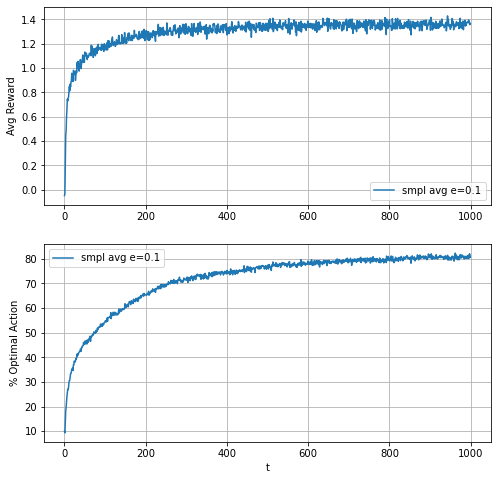

In [5]:
fig,ax = plt.subplots(2,1,figsize=(8,8))

ax[0].plot(R, label='smpl avg e=0.1')
ax[0].set_ylabel('Avg Reward')
ax[1].plot(A*100, label='smpl avg e=0.1')
ax[1].set_ylabel('% Optimal Action')
ax[1].set_xlabel('t')

for i in ax.flat:
    i.grid(True)
    i.legend()

In [6]:
R = numpy.zeros((m,n))
A = numpy.zeros((m,n))
for i in tqdm.trange(m):
       
    a = IncrementalAvgLearning(epsilon=0.1)
    a.run(n)
    
    R[i,:] = a.env.R
    A[i,:] = a.env.A == a.env.get_A_optimal()
    

R = numpy.mean(R,axis=0)
A = numpy.mean(A,axis=0)
    

100%|██████████| 2000/2000 [01:16<00:00, 26.13it/s]


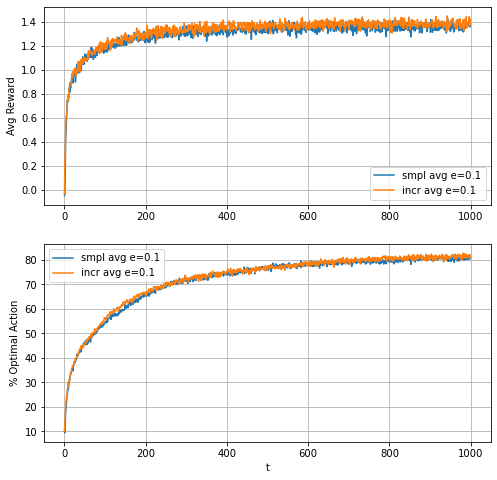

In [7]:
ax[0].plot(R, label='incr avg e=0.1')
ax[0].set_ylabel('Avg Reward')
ax[1].plot(A*100, label='incr avg e=0.1')
ax[1].set_ylabel('% Optimal Action')
ax[1].set_xlabel('t')

for i in ax.flat:
    i.grid(True)
    i.legend()
    
fig

# Exercise 2.5

100%|██████████| 2000/2000 [18:11<00:00,  1.83it/s]


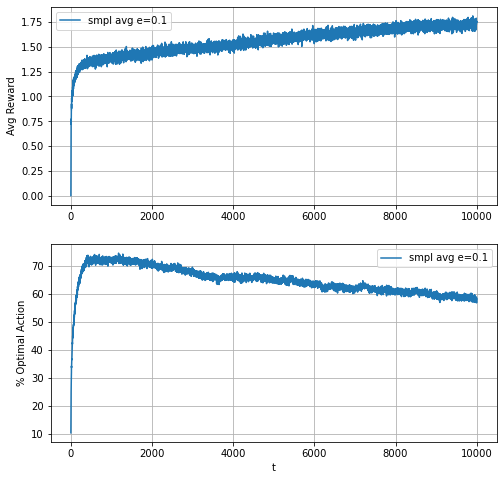

In [8]:
m = 2000
n = 10000

R = numpy.zeros((m,n))
A = numpy.zeros((m,n))
for i in tqdm.trange(m):
       
    a = IncrementalAvgLearning(epsilon=0.1,env=kArmBanditNonstationary)
    a.run(n)
    
    R[i,:] = a.env.R
    A[i,:] = a.env.A_optimal_selected
    
R = numpy.mean(R,axis=0)
A = numpy.mean(A,axis=0)

fig,ax = plt.subplots(2,1,figsize=(8,8))

ax[0].plot(R, label='smpl avg e=0.1')
ax[0].set_ylabel('Avg Reward')
ax[1].plot(A*100, label='smpl avg e=0.1')
ax[1].set_ylabel('% Optimal Action')
ax[1].set_xlabel('t')

for i in ax.flat:
    i.grid(True)
    i.legend()

100%|██████████| 2000/2000 [18:07<00:00,  1.84it/s]


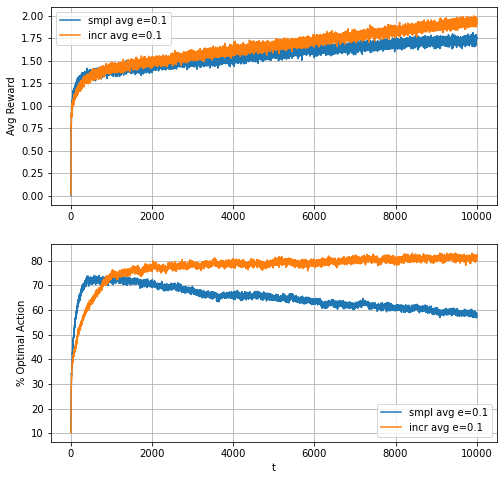

In [9]:
R = numpy.zeros((m,n))
A = numpy.zeros((m,n))
for i in tqdm.trange(m):
       
    a = IncrementalFixedStep(epsilon=0.1, env=kArmBanditNonstationary)
    a.run(n)
    
    R[i,:] = a.env.R
    A[i,:] = a.env.A_optimal_selected

R = numpy.mean(R,axis=0)
A = numpy.mean(A,axis=0)

ax[0].plot(R, label='incr avg e=0.1')
ax[0].set_ylabel('Avg Reward')
ax[1].plot(A*100, label='incr avg e=0.1')
ax[1].set_ylabel('% Optimal Action')
ax[1].set_xlabel('t')

for i in ax.flat:
    i.grid(True)
    i.legend()
    
fig

# Exercise 2.6

If some episodes perform well early one, they should continue to. 
It indicates that initially we choose the optimal actions, but then explore, eventually comming back to the optimal actions.
Maybe it is to do with the fixed step biasing early actions that lead to greater future rewards?

# Exercise 2.7 
TODO - need pen and paper

# Exercise 2.8
TODO - 

# Exercise 2.9